# Analyzing Time Series Data

-----

A time series data is a series of data points indexed in time order, often with equal intervals between indexes. In this notebook, we introduce how to work efficiently with time series data in Python, by using the Pandas library.

-----

## Table of Contents


[Data](#Data)

[Handle Missing Values](#Handle-Missing-Values)

[Plot Time Series](#Plot-Time-Series)

[Date Slicing](#Date-Slicing)

[Rolling Statistics](#Rolling-Statistics)

[Resampling](#Resampling)

[Seasonal Decomposition](#Seasonal-Decomposition)


-----

Before proceeding with the rest of this notebook, we first include the notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

# Extra imports
from datetime import datetime

-----

[[Back to TOC]](#Table-of-Contents)

## Data

To demonstrate working with dates and times by using the Pandas library, we will load a new data set into our notebook. This data contains measurements of the environment over a number of years in Beijing. The dataset is a subset of the original dataset which can be found at the [UCI Machine Learning Repository][uci].


In the next Code cell, we first load the dataset and display five sample rows in the dataset.

-----
[uci]:https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [2]:
# Load local data file
df = pd.read_csv('data/beijing_2010_2014.csv')
df.sample(5)

,year,month,day,hour,pm2.5,TEMP
13736,2011,7,27,8,42.0,25.0
29222,2013,5,2,14,98.0,24.0
23410,2012,9,2,10,9.0,19.0
12671,2011,6,12,23,45.0,23.0
39425,2014,7,1,17,121.0,31.0


-----

To work with time data by using Pandas, it is more efficient to have a time stamp index. We create this new index in the next few Code cells. 

First, we generate a new time stamp feature, called `TS`, that combines the year, month, day, and hour of observation by using lambda function. This lambda function is applied on the whole dataframe. `axis=1` indicates the lambda function is applied at row level, which means `x` is a row in the DataFrame. We then create datetime object from the `year, month, day, hour` features of each row.  

Next, to analyze time series data, we need a datetime index. In this dataset, we use the new `TS` feature to create  the datetime index. We call Pandas `DatetimeIndex` function to create a datetime index from `TS`, then set it as the DataFrame's index.

Then, we display several observations at random, indicating the extra columns. 

Next, we drop these extra columns, creating a compact DataFrame with the datetime index and features of interest, `pm2.5` and `TEMP`.

Finally, we display the basic information of the dataset. The dataset has total 43824 observations. There is no missing value in `TEMP`, yet there are some missing values in `pm2.5` feature. 

-----

In [3]:
# Build Timestamp Feature
df['TS'] = pd.to_datetime(df.apply(lambda x:
                                   datetime(int(x.year), int(x.month), int(x.day), int(x.hour)),
                                   axis=1))
df.head()

,year,month,day,hour,pm2.5,TEMP,TS
0,2010,1,1,0,NaN,-11.0,2010-01-01 00:00:00
1,2010,1,1,1,NaN,-12.0,2010-01-01 01:00:00
2,2010,1,1,2,NaN,-11.0,2010-01-01 02:00:00
3,2010,1,1,3,NaN,-14.0,2010-01-01 03:00:00
4,2010,1,1,4,NaN,-12.0,2010-01-01 04:00:00


In [4]:
# Convert TS to DataFrame Index
df.index = pd.DatetimeIndex(df.TS)
# Index works, but extra columns
df.sample(5)

,year,month,day,hour,pm2.5,TEMP,TS
TS,,,,,,,
2010-12-29 15:00:00,2010,12,29,15,21.0,-1.0,2010-12-29 15:00:00
2013-01-29 02:00:00,2013,1,29,2,472.0,-6.0,2013-01-29 02:00:00
2010-07-14 23:00:00,2010,7,14,23,161.0,25.0,2010-07-14 23:00:00
2013-09-12 16:00:00,2013,9,12,16,160.0,27.0,2013-09-12 16:00:00
2013-08-04 03:00:00,2013,8,4,3,90.0,24.0,2013-08-04 03:00:00


In [5]:
# Remove extra columns
df.drop(['year', 'month', 'day', 'hour', 'TS'], axis=1, inplace=True)
# We now have a compact DataFrame
df.sample(5)

,pm2.5,TEMP
TS,,
2012-08-06 12:00:00,61.0,32.0
2013-12-08 16:00:00,13.0,10.0
2012-03-26 06:00:00,152.0,2.0
2012-01-15 05:00:00,NaN,-7.0
2011-09-22 15:00:00,14.0,28.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
pm2.5    41757 non-null float64
TEMP     43824 non-null float64
dtypes: float64(2)
memory usage: 1.0 MB


-----

[[Back to TOC]](#Table-of-Contents)

## Handle Missing Values

Time series data is time dependent, so it's subject to have missing values due to problems in recording data at certain time. To make time series analysis more effective, missing values need to be handled, either dropped or filled with certain value. For time series data, we normally don't want to drop missing values since we will lose valuable information in other features as well as some time index. To fill missing values, a common practice is  filling with certain values like mean value of the feature. However, this approach doesn't work well with time series data. In time series data, value of a feature at certain time normally has very high correlation to the values immediately before and after the time. For example, temperature at 8AM is normally between temperatures at 7AM and 9AM on the same day. It doesn't make sense to use the mean temperature of the whole column to fill the missing temperature.

Missing value handling in time series data is a big topic. Depending on the characteristic of the data, there are many different approaches to fill the missing values. In this notebook, we will not explore this topic in depth. We will introduce a simple way to handle missing values in time series data by using `interpolate` function in Pandas module.

Both Pandas DataFrame and Series have `interpolate` function. The function takes many arguments, of which we will focus on two in this notebook:
- `method`:  Determines how missing value is estimated. Default is 'linear' which ignore the index and treat the values as equally spaced.
- `limit_direction`: 'forward', 'backward' or 'both'. Default is 'forward'.

We will demonstrate `interpolate` function with an example in following Code cells. In the first Code cell below, we create a DataFrame with some missing value in column `data`. Then we call `interpolate` function with default argument values on `data` feature to fill missing values and create a new feature `target`. 

Comparing `data` and `target` columns, we can see that:
- Missing value in the third row is filled with value 2.0, which is mean of values in second and fourth rows. 
- Missing value in the fifth row is filled with the value in fourth row because there are no values after the fifth row.
- Missing value in the first row is not filled since we use default `limit_direction` which is `'forward'`.

In the next Code cell, we set `limit_direction='both'`. This time the first row is filled with value in the second row.

In [7]:
df_missing = pd.DataFrame({'data':[np.nan, 1, np.nan, 3, np.nan]})
df_missing

,data
0,NaN
1,1.0
2,NaN
3,3.0
4,NaN


In [8]:
df_missing['target'] = df_missing.data.interpolate()
df_missing

,data,target
0,NaN,NaN
1,1.0,1.0
2,NaN,2.0
3,3.0,3.0
4,NaN,3.0


In [9]:
df_missing['target'] = df_missing.data.interpolate(limit_direction='both')
df_missing

,data,target
0,NaN,1.0
1,1.0,1.0
2,NaN,2.0
3,3.0,3.0
4,NaN,3.0


---
With time series data, the index is time index, so we will use `'time'` method when calling `interpolate` function. If the time index is not evenly spaced, the missing value estimation will consider the real gap between time indexes. In the next Code cell, we will fill missing values for our time series dataset with `method='time'` and `limit_direction='both'`.

Please note that there are many other `method` options but they are out of the scope of this lesson.

In [10]:
#fill missing values in pm2.5 column
df['pm2.5'] = df['pm2.5'].interpolate(method='time', limit_direction='both')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
pm2.5    43824 non-null float64
TEMP     43824 non-null float64
dtypes: float64(2)
memory usage: 1.0 MB


-----

[[Back to TOC]](#Table-of-Contents)

## Plot Time Series

Pandas provides considerable functionality to work with time series data. The following Code cell demonstrates how easy it can be to plot time series data by using Pandas. We directly call `plot` function from `TEMP` column. The function will automatically use the datetime index as x axis. It's smart enough to only use year as x tick value. 

In the `plot` function, we pass two arguments, `lw` which defines the line width of the plot, and `alpha`, which defines the transparency of the plotting line. We set the two arguments to make the plot more readable. Remember that there are over 40 thousand observations in the dataset. If we don't set these two arguments and take the default values, the plot will look like one thick wave.

-----

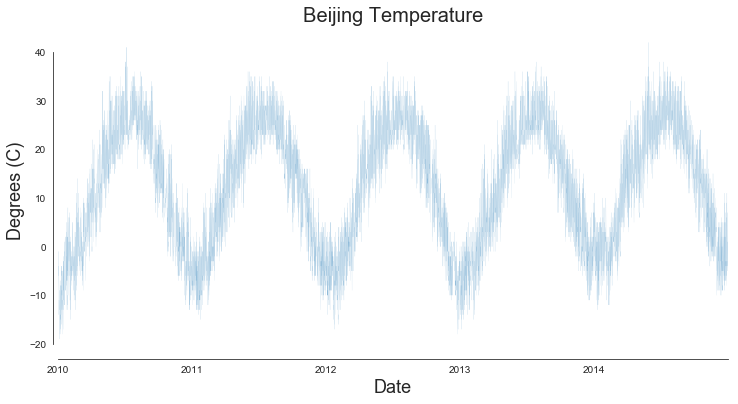

In [11]:
# Plot Temperature 
fig, ax = plt.subplots(figsize=(12, 6))

df.TEMP.plot(lw=0.1, alpha=0.5)

ax.set(title='Beijing Temperature',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Date Slicing

One of the most useful features the Pandas library provides is the ability to select instances from a DataFrame by using the slice notation on a time series index. The following Code cells demonstrate:
- How to select all instances for a given date.
- How to apply a mask to select all instances for a given month where a condition is true.
- How to apply a function to all observations over a given year (in this case via the `describe` function).
- How to plot a subset of observations of one feature.

-----

In [12]:
# Select instances for a given date
df['2011-06-01']

,pm2.5,TEMP
TS,,
2011-06-01 00:00:00,12.0,21.0
2011-06-01 01:00:00,17.0,22.0
2011-06-01 02:00:00,12.0,22.0
2011-06-01 03:00:00,16.0,22.0
2011-06-01 04:00:00,8.0,22.0
2011-06-01 05:00:00,11.0,22.0
2011-06-01 06:00:00,17.0,21.0
2011-06-01 07:00:00,8.0,22.0
2011-06-01 08:00:00,16.0,25.0


In [13]:
# Select instances from date range and mask
df['2011-01'][df.TEMP > 3]

,pm2.5,TEMP
TS,,
2011-01-31 11:00:00,19.0,4.0
2011-01-31 12:00:00,23.0,6.0
2011-01-31 13:00:00,23.0,7.0
2011-01-31 14:00:00,17.0,8.0
2011-01-31 15:00:00,21.0,8.0
2011-01-31 16:00:00,18.0,8.0
2011-01-31 17:00:00,28.0,7.0
2011-01-31 18:00:00,24.0,6.0
2011-01-31 19:00:00,46.0,4.0


In [14]:
# Statitics of year 2011, same as df['2011']
df['2011-01':'2011-12'].describe()

,pm2.5,TEMP
count,8760.000000,8760.000000
mean,97.772089,12.565297
std,90.372973,11.974841
min,2.000000,-15.000000
25%,28.000000,2.000000
50%,72.000000,14.000000
75%,133.910000,23.000000
max,595.000000,36.000000


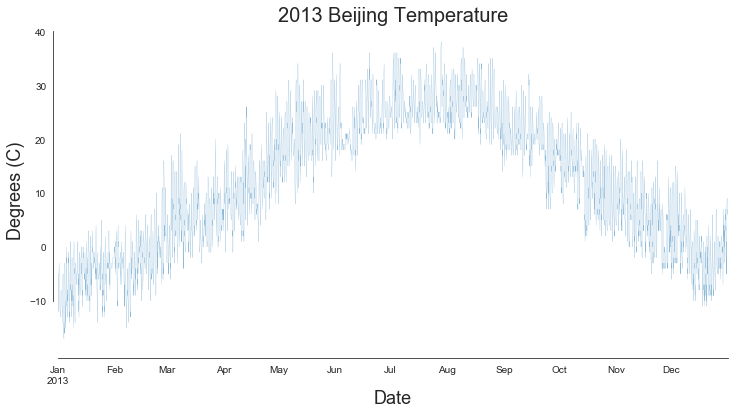

In [15]:
# Plot one year's temperature data
fig, ax = plt.subplots(figsize=(12, 6))

df.TEMP['2013'].plot(lw=0.25, alpha=0.5)

ax.set(title='2013 Beijing Temperature',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Rolling Statistics

Often with time series data, we wish to smooth over the data when computing statistical summaries of the data. This operation is known as _rolling_ statistics since the statistical measure is determined by rolling over multiple observations. The technique used to compute these quantities in Pandas requires the creation of a [`Rolling` object][1] from the DataFrame of interest. This object can be used repeatedly to compute rolling statistics for the same date and time window. When creating this `Rolling` object, which is done by using the `rolling` method on the DataFrame of interest, we can specify the window size by using the `window` parameter. One can either specify the window size explicitly (e.g., a number of hours or days, using the default time interval of the data) or by using a [special code][2] to indicate a special day or time. Given a `Rolling` object, we can compute a number of different rolling statistics, including the mean, median, and standard deviation by applying the relevant function: `mean`, `median`, and `std`.

In the following Code cell, we create a rolling statistic by setting window to 24x14. Since our data is hourly data, this window value means we are going to calculate rolling statistics on previous 24x14 hours(or two weeks) data.

Note, these functions do not produce a single statistic, but instead create a new DataFrame (or Series if only one column is selected form the original DataFrame) that has rows corresponding to the rolling statistic (e.g., the mean is computed by averaging over multiple observations). Thus, at the start of the DataFrame, the instances contain `NaN` values until we have accumulated enough observations to fully populate the rolling window used to compute the statistic. This is demonstrated by calling the `head` and `tail` functions on the new DataFrame, after which we plot the time series data along with the rolling statistics for comparison.

-----

[1]: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

[2]: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

In [16]:
# Compute rolling statistic (hours * days)
roll_df = df.rolling(24*14)
mn = roll_df.mean()
md = roll_df.median()
std = roll_df.std()

In [17]:
# Display start of new DataFrame
mn.head()

,pm2.5,TEMP
TS,,
2010-01-01 00:00:00,NaN,NaN
2010-01-01 01:00:00,NaN,NaN
2010-01-01 02:00:00,NaN,NaN
2010-01-01 03:00:00,NaN,NaN
2010-01-01 04:00:00,NaN,NaN


In [18]:
# Display end of new DataFrame
mn.tail()

,pm2.5,TEMP
TS,,
2014-12-31 19:00:00,97.845238,-0.669643
2014-12-31 20:00:00,97.273810,-0.669643
2014-12-31 21:00:00,96.574405,-0.666667
2014-12-31 22:00:00,95.928571,-0.669643
2014-12-31 23:00:00,95.428571,-0.660714


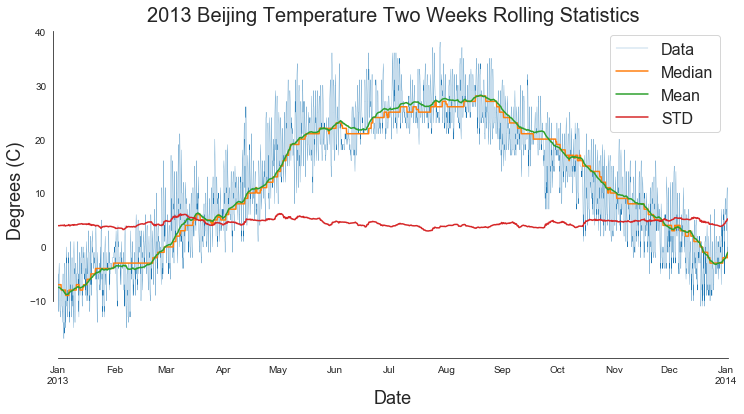

In [19]:
# Plot data and rolling statistics
fig, ax = plt.subplots(figsize=(12, 6))

df.TEMP['2013-01-01':'2014-01-01'].plot(lw=0.25, label='Data')
md.TEMP['2013-01-01':'2014-01-01'].plot(label='Median')
mn.TEMP['2013-01-01':'2014-01-01'].plot(label='Mean')
std.TEMP['2013-01-01':'2014-01-01'].plot(label='STD')

ax.set(title='2013 Beijing Temperature Two Weeks Rolling Statistics',
      xlabel='Date', ylabel = 'Degrees (C)')

ax.legend(loc=1)

sns.despine(offset=5, trim=True)

---
Rolling statistics are widely used in stock trading. For example, the famous death cross appears when 
a stock's short-term moving average crosses below its long-term moving average. Typically, the most common moving averages used in this pattern are the 50-day and 200-day moving averages.

In the following Code cell, we load the weekly Dow Jones Industrial Average and plot the 50-day and 200-day rolling mean(moving average) from year 2006 to 2009. Since the data set is weekly data, we will use 7 weeks and 29 weeks to approximate 50 and 200 days.

From the plot we can see that the first death cross appears just before year 2008.

In [20]:
df_dow = pd.read_csv('data/dow_weekly_all.csv')
df_dow.index = pd.DatetimeIndex(pd.to_datetime(df_dow.Date))
df_dow.drop('Date', inplace=True, axis=1)
df_dow.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-28,1277.719971,1305.099976,1266.890015,1277.719971,1277.719971,55430000
1985-02-04,1272.079956,1301.130005,1268.989990,1289.969971,1289.969971,59480000
1985-02-11,1287.989990,1307.530029,1266.339966,1282.020020,1282.020020,61270000
1985-02-18,1279.810059,1292.510010,1269.989990,1275.839966,1275.839966,34550000
1985-02-25,1269.989990,1309.959961,1263.910034,1299.359985,1299.359985,55750000


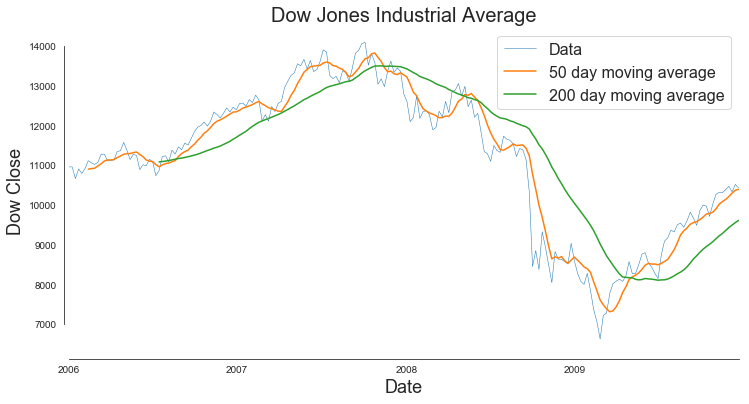

In [21]:
roll7_df = df_dow['2006':'2009'].rolling(7)
roll29_df = df_dow['2006':'2009'].rolling(29)
# Plot data and rolling statistics
fig, ax = plt.subplots(figsize=(12, 6))

df_dow['2006':'2009'].Close.plot(lw=0.5, label='Data')
roll7_df.mean().Close.plot(label='50 day moving average')
roll29_df.mean().Close.plot(label='200 day moving average')

ax.set(title='Dow Jones Industrial Average',
      xlabel='Date', ylabel = 'Dow Close')

ax.legend()

sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Resampling

Pandas also enables a time series to be resampled. A [`Resampler` object][1] is created in a similar manner as a `GroupBy` object within Pandas. The `Resampler` object typically takes one parameter which is a time window, often specified by a code.

Pandas provides a number of special codes to indicate these times. Common codes include:
- B:       business day frequency
- D:       calendar day frequency
- W:       weekly frequency
- M:       month end frequency
- BM:      business month end frequency
- MS:      month start frequency
- BMS:     business month start frequency
- Q:       quarter end frequency
- A:       year end frequency
- BA:      business year end frequency
- AS:      year start frequency
- BAS:     business year start frequency
- BH:      business hour frequency
- H:       hourly frequency

For a complete list of the resampling codes, please refer to [Pandas resampling document][2].

When resampling a data set, a Resampler object is created. We can then call a function like `mean()`, `sum()` etc. to get a DataFrame(or Series) with resampling values. The new DataFrame (or Series) will be created from the original data set, but each new instance contains the observation at a new time. 

In the following code, we use resampling code `BMS`, which corresponds to the start of the business month to create a resampled `Series` by using the _mean()_ function from the temperature data. 

In the resampled dataset, there's time index `2010-05-03` instead of `2010-05-01` because we use resample code `BMS` which means business month start. Both 2010-05-01 and 2010-05-02 are not business days(they are either weekends or holidays), so 2010-05-03 is selected as the time index for that month.

Finally, we plot the resampled data and the original data to provide a direct visual comparison.

-----
[1]: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
[2]: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

In [22]:
# Start of Temperature column
df.TEMP.head()

TS
2010-01-01 00:00:00   -11.0
2010-01-01 01:00:00   -12.0
2010-01-01 02:00:00   -11.0
2010-01-01 03:00:00   -14.0
2010-01-01 04:00:00   -12.0
Name: TEMP, dtype: float64

In [23]:
# Start of resmpled temperature column
df.TEMP.resample('BMS').mean().head()

TS
2010-01-01    -6.162634
2010-02-01    -1.922619
2010-03-01     3.293011
2010-04-01    11.528646
2010-05-03    20.727011
Freq: BMS, Name: TEMP, dtype: float64

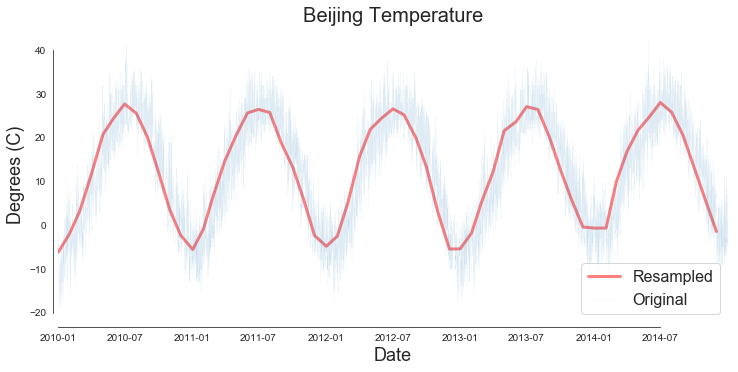

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

df.TEMP.resample('BMS').mean().plot(lw=3, alpha=0.5, color='r', label='Resampled', ax=ax)
df.TEMP.plot(lw=0.1, alpha=0.25, label='Original', ax=ax)

ax.set(title='Beijing Temperature',
      xlabel='Date', ylabel = 'Degrees (C)')

ax.legend(loc=4)
sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>


In the preceding cells, we introduced how to analyze time series data with the Pandas library. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Analyze a different feature, rather than the `TEMP` feature analyzed above. How does the plot change?
1. Change the size of the rolling window used to compute the statistics earlier to be seven days and two months. How does the plot change?
2. Try using different resampling periods (look at Pandas documentation for the appropriate codes).

-----

-----

[[Back to TOC]](#Table-of-Contents)


## Seasonal Decomposition

Time series data can be considered as a combination of level, trend, seasonality, and noise components.
- Level: The average value in the series.
- Trend: The underlying trend in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series, aka residual.

We can perform automatic seasonal decomposition on a time series data set by using the statsmodels library. We demonstrate this in the following Code cells, where we decomposite `TEMP` feature in our DataFrame. We then plot the first week of June 2010 data in the different trend, seasonal, and residual to verify the efficacy of the decomposition. The seasonal plot demonstrates the pattern of daily temperature change.

-----

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.TEMP)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

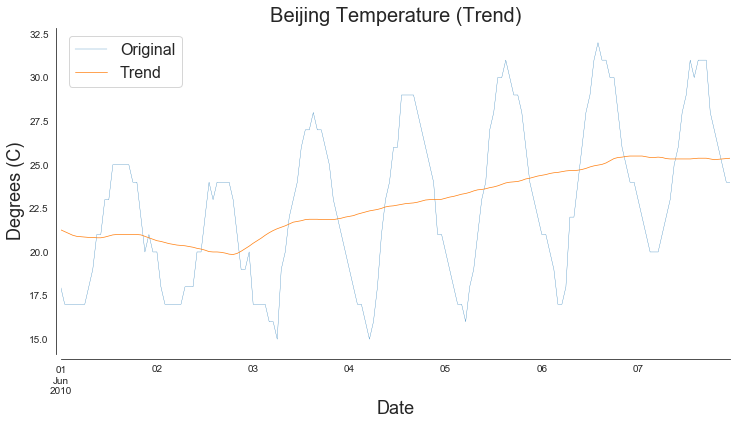

In [26]:
# Plot trend
fig, ax = plt.subplots(figsize=(12, 6))

df['2010-06-01':'2010-06-07'].TEMP.plot(lw=0.3, alpha=1, label='Original')
trend['2010-06-01':'2010-06-07'].plot(lw=0.7, alpha=1, label='Trend')

ax.set(title='Beijing Temperature (Trend)',
      xlabel='Date', ylabel = 'Degrees (C)')

ax.legend()
sns.despine(offset=5)

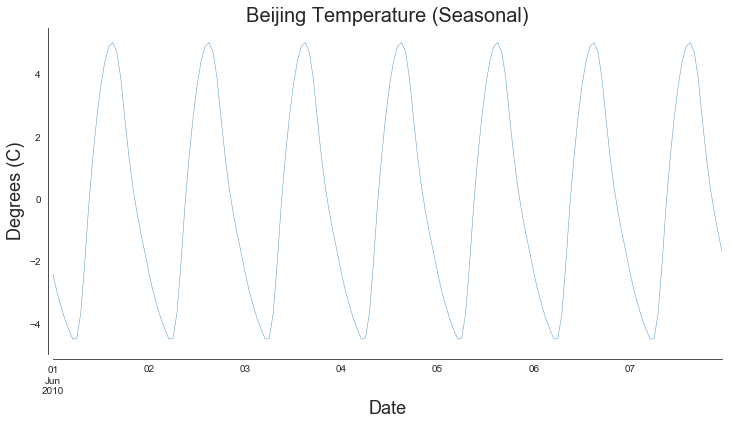

In [27]:
# Plot seasonal
fig, ax = plt.subplots(figsize=(12, 6))

seasonal['2010-06-01':'2010-06-07'].plot(lw=0.5, alpha=0.75)

ax.set(title='Beijing Temperature (Seasonal)',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5)#, trim=True)

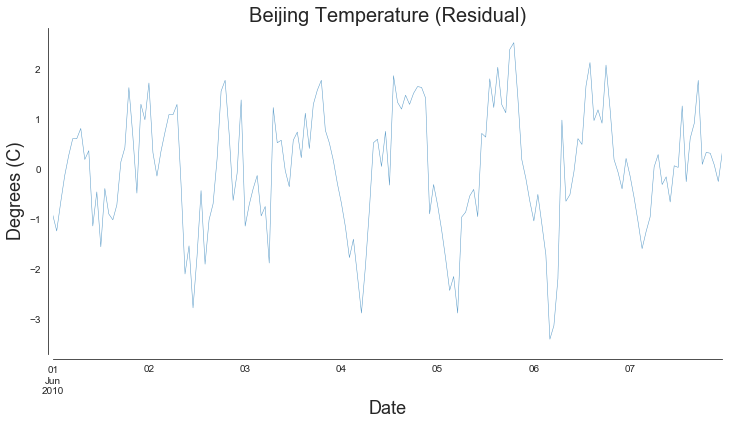

In [28]:
# Plot residual
fig, ax = plt.subplots(figsize=(12, 6))

residual['2010-06-01':'2010-06-07'].plot(lw=0.5, alpha=0.75)

ax.set(title='Beijing Temperature (Residual)',
      xlabel='Date', ylabel = 'Degrees (C)')

sns.despine(offset=5)#, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Time Series Forecasting

Time series forecasting is using the machine learning modeling for Time Series data to predict future values. The seasonality decomposition is used frequently in time series forecasting. There are many models for time series forecast but they are out of the scope of this lesson. If you are interested in this topic, you may find articles in the readings of this lesson.

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Introduction to [working with time series data][pat] by using Pandas
2. Worked example of using [Pandas for time series analysis][pate]
2. Analyzing stock data with [Pandas][nbta]
3. [Financial analysis][fapt] by using Pandas
3. [Financial analysis with Google trends][fapt2] by using Pandas
4. [Time series plots][tspp] by using Python
5. Somewhat dated discussion of using Pandas for [time series analysis][pbts]
5. [Using Pandas for time series analysis][pt]

-----

[pat]: http://www.vincentgregoire.com/introduction-to-pandas/

[pate]: http://www.vincentgregoire.com/crsp-example-dividends/

[nbta]: http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/misc/TimeSeriesStockAnalysis.ipynb

[fapt]: https://github.com/twiecki/financial-analysis-python-tutorial/blob/master/1.%20Pandas%20Basics.ipynb

[fapt2]: https://github.com/twiecki/financial-analysis-python-tutorial/blob/master/2.%20Pandas%20replication%20of%20Google%20Trends%20paper.ipynb

[tspp]: http://www.blackarbs.com/blog/advanced-time-series-plots-in-python/1/6/2017

[pbts]: http://earthpy.org/pandas-basics.html

[pt]: http://www.marcelscharth.com/python/time.html

[tspr]: http://connor-johnson.com/2014/11/23/time-series-forecasting-in-python-and-r/

[tsd]: https://www.bundesbank.de/Navigation/EN/Statistics/Time_series_databases/Real_Time_Data/realtime_list_node.html?listId=rt_s311_m.de.n.i.io1.acm03.c.i
[tsf]:https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode